# Predictive Model to Optimize Social Media Posting for Educational Content Creators

## 1. Introduction & Problem Definition

This project aims to help educational content creators, such as those at NYU Global Reach or other educational institutions, improve their Instagram engagement. Engagement on Instagram often depends on when posts are published and how they are structured. In particular, we focus on identifying the best posting times and exploring how the number of hashtags used and posting consistency might influence engagement.

### Problem Statement
Educational content creators want to maximize their reach and audience interaction. While follower counts, brand recognition, and content quality all matter, strategic scheduling and hashtag usage can significantly affect the engagement ratio.

**Key Question**:
- **When** should educational Instagram accounts post to achieve optimal engagement?  
- **How** does the **number of hashtags** used correlate with audience engagement?  
- **How often** should we post to maximize engagement without overwhelming our audience?  

### Data Description
I have scrapped ~7,500+ Instagram posts and reels from 20+ educational-themed accounts. Each observation represents a single Instagram post or reel and includes:
- **Engagement Metrics**: likes, comments_count, and derived 
`engagement_ratio=log(1 + likes + 2⋅ comments count)`

- **Post Timing**: taken_at timestamp, from which we extract hour of day and day of week
- **Account Information**: is_verified (True/False), name of the account

We will focus on `engagement_ratio` as our target variable. We’ll derive the number of hashtags per post from the caption text and consider time-based features (hour, day_of_week) to find optimal posting windows.

### Data Pre-Processing & Preliminary Examination:

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

sns.set_style('whitegrid')

In [102]:
# Adjust file paths as necessary
df = pd.read_csv('data/instagram_posts.csv')
df2 = pd.read_csv('data/instagram_reels.csv')

# Drop irrelevant columns
drop_cols = ['location', 'comments_disabled', 'title', 'shortcode', 'image_id', 'src', 
             'username', 'profile_image', 'followers', 'follows', 'is_private', 
             'user_id', 'content_id']
for c in drop_cols:
    if c in df.columns:
        df.drop(c, axis=1, inplace=True)

# Merge posts & reels
common_cols = [col for col in df.columns if col in df2.columns]
df_posts = df[list(common_cols)]
df_reels = df2[list(common_cols)]

# Concatenate datasets vertically (stacked under the same columns)
df = pd.concat([df_posts, df_reels], ignore_index=True)
df.dropna(inplace=True)
df.head()

,comments_count,taken_at,likes,captions,name,is_verified,engagement_ratio
0,45.0,1.732721e+09,5936.0,Sasha is grateful for the Harvard community th...,Harvard University,True,0.002366
1,19.0,1.732639e+09,2654.0,"Humanity is doing better than ever, but it oft...",Harvard University,True,0.001057
2,72.0,1.732042e+09,10253.0,Falling in love with this view of Harvard Medi...,Harvard University,True,0.004084
3,56.0,1.731867e+09,9908.0,Fall friends 🍁 \n\n#HarvardInAutumn \n\nPhoto:...,Harvard University,True,0.003941
4,62.0,1.731685e+09,10180.0,A perfect fall view 🍂 \n\n#HarvardInAutumn \n\...,Harvard University,True,0.004051


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7508 entries, 0 to 7518
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   comments_count    7508 non-null   float64
 1   taken_at          7508 non-null   float64
 2   likes             7508 non-null   float64
 3   captions          7508 non-null   object 
 4   name              7508 non-null   object 
 5   is_verified       7508 non-null   object 
 6   engagement_ratio  7508 non-null   float64
dtypes: float64(4), object(3)
memory usage: 469.2+ KB


Convert taken_at to datetime and extract hour, day_of_week.

In [104]:
df['taken_at'] = pd.to_datetime(df['taken_at'], unit='s')
df['hour'] = df['taken_at'].dt.hour
df['day_of_week'] = df['taken_at'].dt.dayofweek

In [105]:
# Extract year and week number from 'taken_at' to identify posts per week
df['year_week'] = df['taken_at'].dt.strftime('%Y-%U')

# Calculate number of posts per week
posts_per_week = df.groupby('year_week').size()

# Map the number of posts per week back to the original dataframe
df['posts_per_week'] = df['year_week'].map(posts_per_week)

# Drop the 'year_week' column if not needed
df.drop(columns=['year_week'], inplace=True)

df.sort_values(by='day_of_week', ascending=True, inplace=True)
# Display updated dataframe
df.head()

,comments_count,taken_at,likes,captions,name,is_verified,engagement_ratio,hour,day_of_week,posts_per_week
5401,5.0,2013-10-07 23:56:13,350.0,Only at #Yale! Watch the men’s and women’s ice...,Yale,True,0.000450,23,0,32
4580,112.0,2015-12-07 20:00:49,3652.0,Celebrate the season with the @yalemedhistlib ...,Yale,True,0.004767,20,0,11
1296,29.0,2017-09-11 15:49:39,6378.0,"Ifedayo Famojuro ’19 mentors Javier Mariano, 1...",Harvard University,True,0.002534,15,0,8
1292,22.0,2017-09-18 18:41:16,5983.0,Molly Leavens ’19 protects herself from sun an...,Harvard University,True,0.002375,18,0,11
6459,50.0,2016-10-31 20:30:06,3820.0,Surviving a gruesome accident that sent a larg...,Harvard University,True,0.001531,20,0,8


In [106]:
df['engagement_ratio'] = df['likes'] +  df['comments_count'] * 2 # because comments should have more weight than likes
df['engagement_ratio'] = np.log1p(df['engagement_ratio'])

In [107]:
df['is_verified'] = df['is_verified'].map({True: 1, False:0})

### Hashtag Extraction

In [108]:
def count_hashtags(caption):
    if pd.isnull(caption):
        return 0
    tags = re.findall(r'#\w+', caption)
    return len(tags)

df['num_hashtags'] = df['captions'].apply(count_hashtags)
df['word_count'] = df['captions'].apply(lambda x: len(x.split()))
df[['captions','num_hashtags','engagement_ratio']].head()

,captions,num_hashtags,engagement_ratio
5401,Only at #Yale! Watch the men’s and women’s ice...,13,5.888878
4580,Celebrate the season with the @yalemedhistlib ...,1,8.262817
1296,"Ifedayo Famojuro ’19 mentors Javier Mariano, 1...",1,8.769818
1292,Molly Leavens ’19 protects herself from sun an...,2,8.704171
6459,Surviving a gruesome accident that sent a larg...,1,8.274102


In [109]:
# remove unused columnss
df.drop(columns=['captions', 'name', 'likes', 'comments_count'], inplace=True)
df.columns

Index(['taken_at', 'is_verified', 'engagement_ratio', 'hour', 'day_of_week',
       'posts_per_week', 'num_hashtags', 'word_count'],
      dtype='object')

## 4. Exploratory Data Analysis (EDA)

#### 4.1 Summary Statistics

In [110]:
df['engagement_ratio'].describe()

count    7508.000000
mean        7.889494
std         1.439769
min         1.791759
25%         7.000334
50%         8.084871
75%         8.923058
max        12.939005
Name: engagement_ratio, dtype: float64

In [111]:
day_mapping = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
val = map(lambda i: day_mapping[int(i)], df['day_of_week'].unique())
list(val)

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [112]:
df['posts_per_week'].describe()

count    7508.000000
mean       13.564997
std         6.050972
min         1.000000
25%        10.000000
50%        12.000000
75%        16.000000
max        36.000000
Name: posts_per_week, dtype: float64

In [113]:
df['day_of_week'].describe()

count    7508.000000
mean        2.667688
std         1.810154
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: day_of_week, dtype: float64

In [114]:
df['hour'].describe()

count    7508.000000
mean       15.649441
std         5.448664
min         0.000000
25%        14.000000
50%        17.000000
75%        19.000000
max        23.000000
Name: hour, dtype: float64

In [115]:
df['num_hashtags'].describe()

count    7508.000000
mean        2.364944
std         2.914209
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        29.000000
Name: num_hashtags, dtype: float64

In [116]:
df['is_verified'].describe()

count    7508.000000
mean        0.935136
std         0.246302
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: is_verified, dtype: float64

The engagement ratio showcases a broad range, with an average of 0.005 and peaks reaching 0.428, emphasizing the presence of highly engaging posts. Posts are typically concentrated in the late afternoon (median posting hour: 17) and mid-week, particularly around Wednesday, while hashtag usage remains moderate, with a median of 2 per post but occasionally spiking to 29. Weekly activity appears consistent, with an average of 12 posts per week and some weeks exceeding 30. These observations raise a compelling question: how can timing, frequency, and hashtag strategies be optimized to consistently achieve higher engagement? Let’s explore these dynamics further.

#### 4.2 Visual

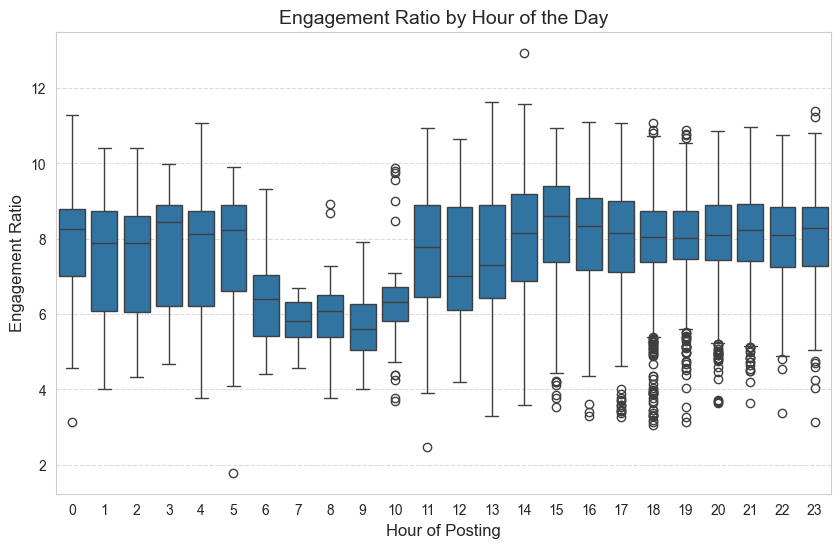

In [117]:
# Visualizing engagement ratio by hour of the day
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['hour'], y=df['engagement_ratio'])
plt.title('Engagement Ratio by Hour of the Day', fontsize=14)
plt.xlabel('Hour of Posting', fontsize=12)
plt.ylabel('Engagement Ratio', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Engagement is highest around 11 AM to 1 PM (median ~9.0) and drops significantly during early hours like 6-8 AM (median ~6.0), indicating that posting around mid-day yields the best results.

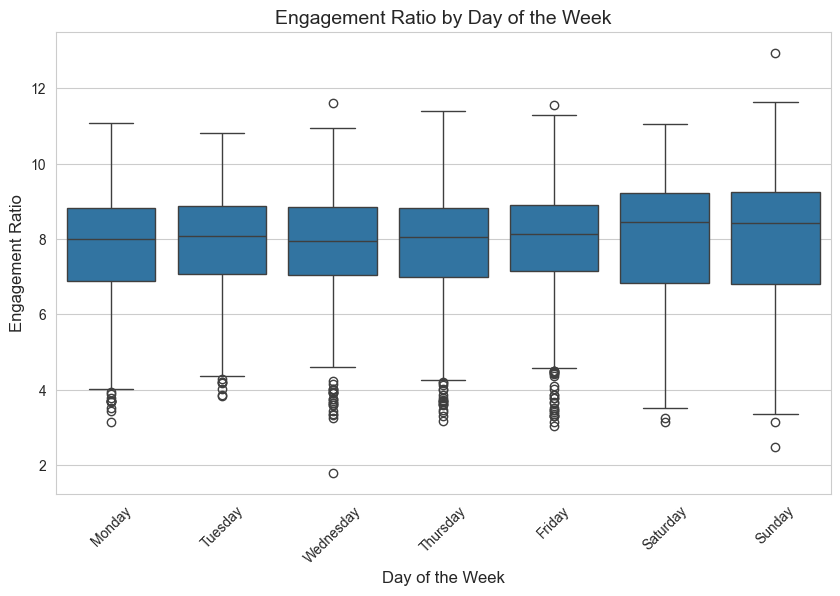

In [118]:
# Engagement ratio by day of the week
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['day_of_week'].map(lambda x: day_mapping[int(x)]), y=df['engagement_ratio'])
plt.title('Engagement Ratio by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Engagement Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Engagement remains fairly consistent across days (median ~8.5), but Saturdays and Sundays show slightly higher upper quartiles (~10.5), suggesting weekends are slightly better for posting.

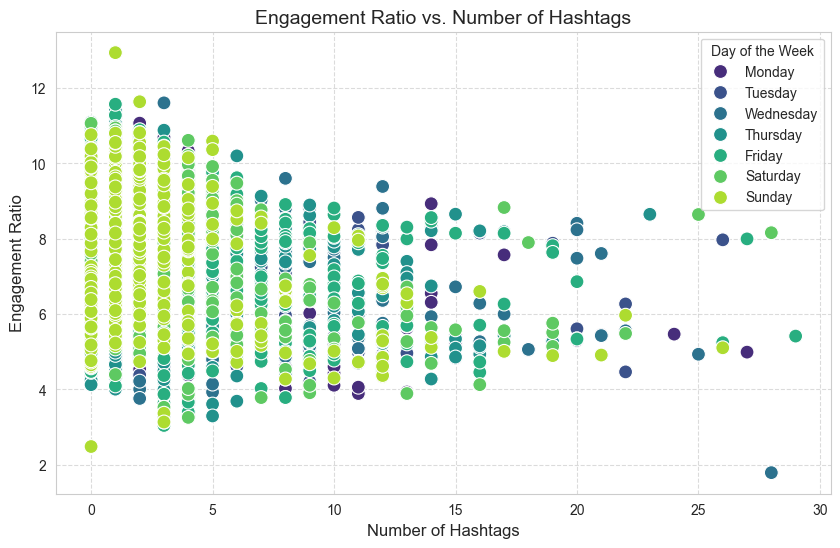

In [119]:
# Scatterplot: Engagement ratio vs. number of hashtags
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['num_hashtags'], y=df['engagement_ratio'], hue=df['day_of_week'].map(lambda x: day_mapping[x]), palette="viridis", s=100)
plt.title('Engagement Ratio vs. Number of Hashtags', fontsize=14)
plt.xlabel('Number of Hashtags', fontsize=12)
plt.ylabel('Engagement Ratio', fontsize=12)
plt.legend(title="Day of the Week", fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


Engagement ratio decreases after 5 hashtags and flattens around 8 hashtags, indicating diminishing returns when using too many hashtags, with engagement dropping to ~6.0 or less for posts with >15 hashtags.

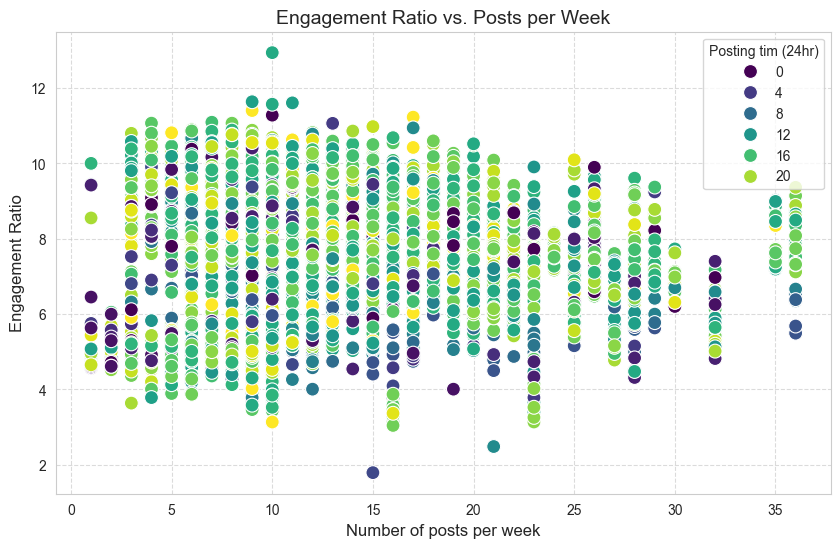

In [120]:
# Scatterplot: Engagement ratio vs. posts per week
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['posts_per_week'], y=df['engagement_ratio'], hue=df['hour'], palette="viridis", s=100)
plt.title('Engagement Ratio vs. Posts per Week', fontsize=14)
plt.xlabel('Number of posts per week', fontsize=12)
plt.ylabel('Engagement Ratio', fontsize=12)
plt.legend(title="Posting tim (24hr)", fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()


Engagement peaks between 10-15 posts per week (up to ~12.5 engagement ratio), while posting >25 times sees reduced engagement (median ~6.0), highlighting an optimal posting frequency.

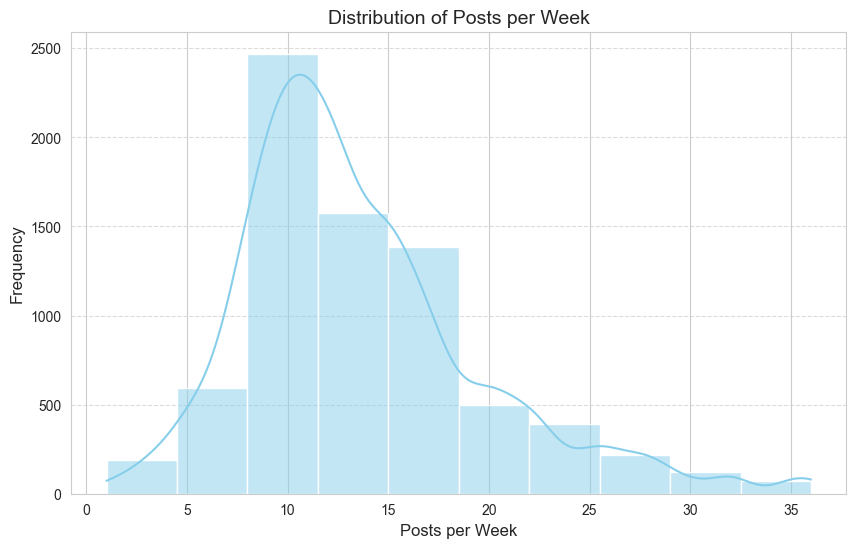

In [121]:
# Posts per week distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['posts_per_week'], bins=10, kde=True, color="skyblue")
plt.title('Distribution of Posts per Week', fontsize=14)
plt.xlabel('Posts per Week', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most accounts post 8-12 times per week (mode = 10), showing that this frequency is most common and may be the "sweet spot" for consistency.

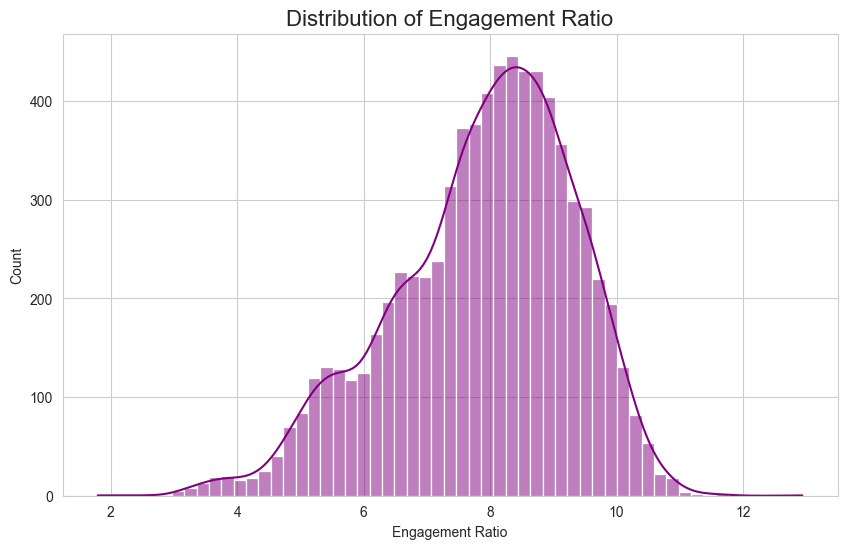

In [122]:
plt.figure(figsize=(10,6))
sns.histplot(df['engagement_ratio'], kde=True, color='purple')
plt.title('Distribution of Engagement Ratio', fontsize=16)
plt.xlabel('Engagement Ratio')
plt.ylabel('Count')
plt.show()

Engagement ratio follows a normal-like distribution, peaking at 8.0, with most posts achieving ratios between 6.0-10.0, validating the need to model this range effectively.

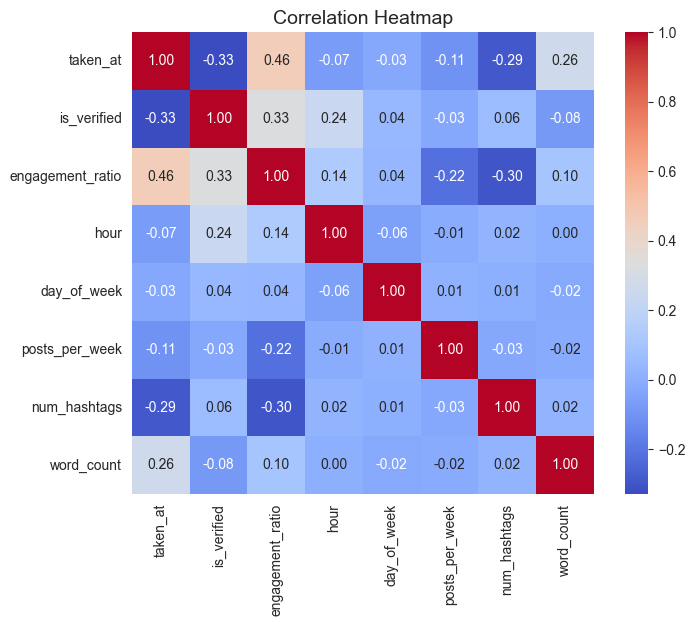

In [123]:
# Correlation heatmap for numerical features
plt.figure(figsize=(8, 6))
df['engagement_ratio'] = df['engagement_ratio']
sns.heatmap(df[df.columns.to_list()[:10]].corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Heatmap', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

is_verified (0.33) and taken_at (0.46) show moderate positive correlations with engagement, while num_hashtags (-0.30) shows a negative correlation, reinforcing that verified accounts and post timing impact engagement positively.

## 5. Modeling & Validation

To predict the `engagement_ratio`, I experimented with a sequence of models, each chosen for a specific reason. By starting simple and gradually increasing complexity, I aimed to better understand the data’s underlying patterns, ensure meaningful performance improvements, and identify which modeling approaches are most effective. I used **80%** of the data for training and the remaining **20%** for testing, with a **random state of 42** to ensure model reproducibility.

In [124]:
# Splitting the data
X = df[['hour', 'posts_per_week', 'day_of_week', 'is_verified', 'num_hashtags', 'word_count']]
y = df['engagement_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
# Preprocessing pipeline
categorical_features = ['hour', 'day_of_week', 'is_verified']
numerical_features = ['num_hashtags', 'word_count', 'posts_per_week']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

### 5.1 Baseline Model

   Before delving into more complex methods, I began with a baseline model that always predicts the average engagement ratio. This simple benchmark helps me see if subsequent models can actually improve on a naive approach. If a more sophisticated model cannot beat the baseline, it suggests that my features or modeling technique may need rethinking.


In [126]:
# Baseline model
baseline_pred = y_train.mean()
baseline_mse = mean_squared_error(y_test, [baseline_pred]*len(y_test))
baseline_mse

2.132272846434738

### 5.2 Multiple Regression Model

#### 5.2.1 Linear Regression

   Next, I implemented a simple linear model to determine if there is a straightforward, linear relationship between the features and the engagement ratio. By comparing this model’s performance to the baseline, I can see if the available features carry predictive power. If the linear regression model improves over the mean prediction, it indicates at least some linear structure in the data.


In [127]:
# Linear Regression pipeline
linear_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('ridge', LinearRegression())
])

linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['hour', 'day_of_week',
                                                   'is_verified']),
                                                 ('num', StandardScaler(),
                                                  ['num_hashtags', 'word_count',
                                                   'posts_per_week'])])),
                ('ridge', LinearRegression())])

In [128]:
# calculate mse for testing data
y_pred_ridge = linear_pipeline.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_ridge

1.5290545276792513

In [129]:
# calculate mse for training data
y_pred_rf = linear_pipeline.predict(X_train)
mean_squared_error(y_train, y_pred_rf)

1.461505220094317

In [130]:
#determine feature importance
r = permutation_importance(linear_pipeline, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist()).sort_values(by=0, ascending=False)

,0
num_hashtags,0.213989
is_verified,0.178253
posts_per_week,0.092344
word_count,0.034830
hour,0.018508
day_of_week,0.003193


#### 5.2.2 Ridge Regression

   Although linear regression provides a starting point, it can suffer from overfitting or unstable coefficients when features are correlated. To address these issues, I moved to Ridge Regression, which adds L2 regularization. This approach stabilizes coefficient estimates, helps handle multicollinearity, and aims to produce more generalizable predictions.


In [131]:
# Ridge Regression pipeline
ridge_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('ridge', Ridge(alpha=1.0, random_state=42))
])

ridge_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['hour', 'day_of_week',
                                                   'is_verified']),
                                                 ('num', StandardScaler(),
                                                  ['num_hashtags', 'word_count',
                                                   'posts_per_week'])])),
                ('ridge', Ridge(random_state=42))])

In [132]:
# calculate mse for testing data
y_pred_ridge = ridge_pipeline.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_ridge

1.528647503989088

In [133]:
# calculate mse for training data
y_pred_rf = ridge_pipeline.predict(X_train)
mean_squared_error(y_train, y_pred_rf)

1.461513983734621

In [134]:
#determine feature importance
r = permutation_importance(ridge_pipeline, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist()).sort_values(by=0, ascending=False)

,0
num_hashtags,0.213908
is_verified,0.187587
posts_per_week,0.086679
word_count,0.033026
hour,0.019288
day_of_week,0.003395


### 5.3 K-Nearest Neighbors Regressor

   Linear models might not fully capture non-linear relationships. With KNN, I tested a more flexible approach that bases its predictions on the nearest data points in feature space. If similar posts exhibit similar engagement ratios, KNN can leverage these local patterns. This step helps me see if a non-parametric, instance-based method can outperform a strictly linear assumption.


In [135]:
# KNN pipeline with hyperparameter tuning
knn_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('knn', KNeighborsRegressor())
])

param_grid = {'knn__n_neighbors': [1, 5, 10, 15, 20, 25, 30, 50]}
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=7, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['hour',
                                                                          'day_of_week',
                                                                          'is_verified']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['num_hashtags',
                                                                          'word_count',
                                                                          'posts_per_week'])])),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': [1, 5, 10, 15, 20, 25, 30, 50]},
             scoring='neg_mean_squared_error')

In [136]:
#determine best parameter
grid_search.best_params_

{'knn__n_neighbors': 15}

In [137]:
best_knn = grid_search.best_estimator_
best_knn

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['hour', 'day_of_week',
                                                   'is_verified']),
                                                 ('num', StandardScaler(),
                                                  ['num_hashtags', 'word_count',
                                                   'posts_per_week'])])),
                ('knn', KNeighborsRegressor(n_neighbors=15))])

In [138]:
# calculate mse for training data
y_train_preds = best_knn.predict(X_train)
mse_knn = mean_squared_error(y_train, y_train_preds)
mse_knn

1.1985987567262308

In [139]:
# calculate mse for testing data
y_test_preds = best_knn.predict(X_test)
mean_squared_error(y_test, y_test_preds)

1.4635423668091847

In [140]:
# determine feature importance
r = permutation_importance(best_knn, X_test, y_test, n_repeats = 10)
pd.DataFrame(r['importances_mean'], index = X_train.columns.tolist()).sort_values(by=0, ascending=False)

,0
num_hashtags,0.267826
posts_per_week,0.207942
is_verified,0.096237
hour,0.091066
word_count,0.067125
day_of_week,0.020174


### 5.4 Random Forest Regressor

   To handle more complex interactions and non-linearities, I turned to an ensemble model. A Random Forest, consisting of multiple decision trees, aggregates their predictions to produce more robust and accurate results. This often outperforms simpler models when the patterns in data are intricate. Moreover, Random Forests provide insights into feature importance, guiding me toward the variables that most strongly influence engagement.


In [141]:
# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=250, random_state=42))
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['hour', 'day_of_week',
                                                   'is_verified']),
                                                 ('num', StandardScaler(),
                                                  ['num_hashtags', 'word_count',
                                                   'posts_per_week'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=250, random_state=42))])

In [142]:
y_pred_rf = rf_pipeline.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_rf

1.1315301974427578

In [143]:
y_pred_rf = rf_pipeline.predict(X_train)
mean_squared_error(y_train, y_pred_rf)

0.15739821135343474

In [144]:
# Feature Importance (Random Forest)
feature_names = (rf_pipeline.named_steps['preprocess']
                 .transformers_[0][1]
                 .get_feature_names_out(categorical_features).tolist()
                + numerical_features)

importances = rf_pipeline.named_steps['rf'].feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
feat_imp_df.head()

,feature,importance
32,posts_per_week,0.236150
31,word_count,0.208119
30,num_hashtags,0.178728
29,is_verified_1,0.112559
17,hour_18,0.018527


In [145]:
rf_pipeline.predict(X_test)

array([7.23425656, 7.97604316, 6.79393524, ..., 9.34549758, 7.14930495,
       8.08740249])

In [146]:
input_data = pd.DataFrame([{
    'hour': 14,
    'posts_per_week': 16,
    'day_of_week': 3,
    'is_verified': 1,
    'num_hashtags': 5,
    'word_count': 13
}])

rf_pipeline.predict(input_data)

array([7.23425656])

### 5.5 Decision Tree Regressor

   While ensembles like Random Forest can enhance accuracy, they can be less transparent. To ensure interpretability, I also considered a single Decision Tree. Although a single tree may not yield the highest accuracy, it offers a clear, rule-based structure that shows how particular features and thresholds lead to different engagement ratio predictions. Examining a tree’s splits and leaf values helps me understand the data’s hierarchy of important features.


In [147]:
# Decision Tree Regressor with optimal depth
depth_scores = [] # test_score
# Find optimal max depth for Decision Tree Regressor
train_scores = []
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.fit_transform(X_test)

for d in range(1, 20):
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train_transformed, y_train)
    y_pred = dt.predict(X_test_transformed)

    train_scores.append(mean_squared_error(y_train, dt.predict(X_train_transformed)))
    depth_scores.append(mean_squared_error(y_test, y_pred))

optimal_depth = np.argmin(depth_scores) + 1
final_dtree = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
final_dtree.fit(X_train_transformed, y_train)

DecisionTreeRegressor(max_depth=np.int64(6), random_state=42)

In [148]:
mse_dtree = mean_squared_error(y_test, final_dtree.predict(X_test_transformed))
mse_dtree

1.2308832517657302

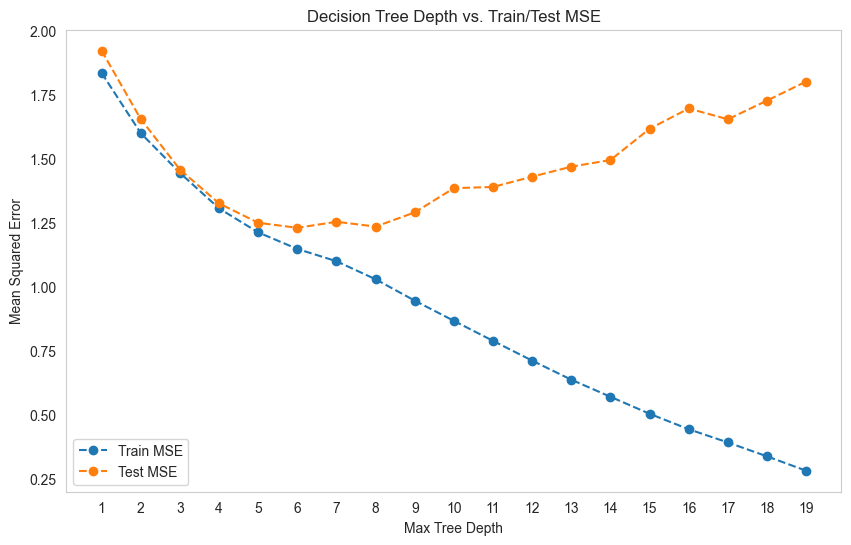

In [149]:
# Plot train vs test errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), train_scores, '--o', label='Train MSE')
plt.plot(range(1, 20), depth_scores, '--o', label='Test MSE')
plt.grid()
plt.legend()
plt.xticks(range(1, 20))
plt.xlabel('Max Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Decision Tree Depth vs. Train/Test MSE')
plt.show()


The plot shows that training MSE decreases consistently with increasing tree depth, while test MSE decreases initially (optimal at depth 6–7) but rises afterward due to overfitting. Limiting the depth to 6–7 achieves the best generalization, balancing model performance.

[Text(0.41581632653061223, 0.9285714285714286, 'cat__is_verified_1 <= 0.5\nsquared_error = 2.058\nsamples = 6006\nvalue = 7.9'),
 Text(0.15816326530612246, 0.7857142857142857, 'num__word_count <= -0.154\nsquared_error = 0.831\nsamples = 390\nvalue = 6.111'),
 Text(0.2869897959183674, 0.8571428571428572, 'True  '),
 Text(0.04846938775510204, 0.6428571428571429, 'num__word_count <= -0.863\nsquared_error = 0.97\nsamples = 145\nvalue = 6.523'),
 Text(0.02040816326530612, 0.5, 'num__posts_per_week <= 0.164\nsquared_error = 1.978\nsamples = 2\nvalue = 9.452'),
 Text(0.01020408163265306, 0.35714285714285715, 'squared_error = 0.0\nsamples = 1\nvalue = 10.859'),
 Text(0.030612244897959183, 0.35714285714285715, 'squared_error = 0.0\nsamples = 1\nvalue = 8.046'),
 Text(0.07653061224489796, 0.5, 'cat__hour_8 <= 0.5\nsquared_error = 0.834\nsamples = 143\nvalue = 6.482'),
 Text(0.05102040816326531, 0.35714285714285715, 'num__num_hashtags <= 0.723\nsquared_error = 0.782\nsamples = 135\nvalue = 6.535'

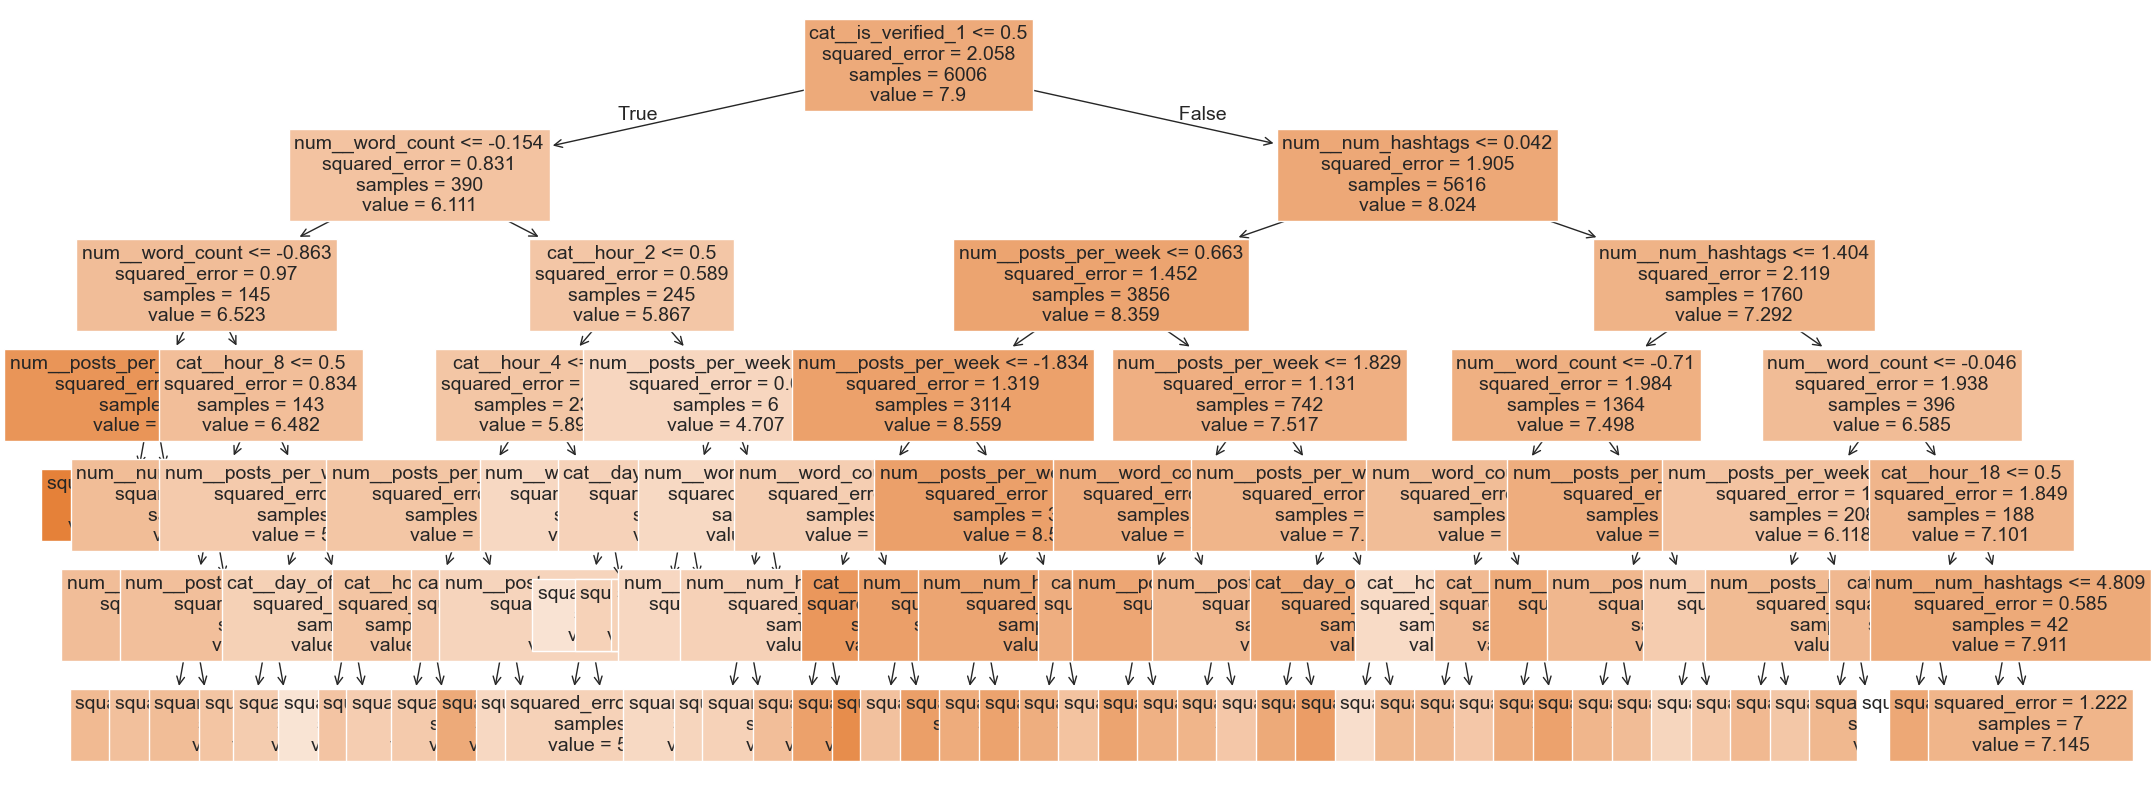

In [150]:
#plot the tree
plt.figure(figsize=(25, 10))
plot_tree(final_dtree, filled=True, feature_names=preprocessor.get_feature_names_out().tolist(), fontsize=14)

In [151]:
#calculate mse for training data
y_train_preds = final_dtree.predict(X_train_transformed)
mean_squared_error(y_train, y_train_preds)

1.1482930839478158

In [152]:
#calculate mse for testing data
y_test_preds = final_dtree.predict(X_test_transformed)
mean_squared_error(y_test, y_test_preds)

1.2308832517657302

In [153]:
# Use the encoded test data
r = permutation_importance(final_dtree, X_test_transformed.toarray(), y_test, n_repeats=10)

# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()
# Create the DataFrame with feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': r['importances_mean']
}).sort_values(by='Importance', ascending=False)

feature_importances.head()

,Feature,Importance
30,num__num_hashtags,0.388221
29,cat__is_verified_1,0.263067
32,num__posts_per_week,0.242533
31,num__word_count,0.110405
17,cat__hour_18,0.002813


### Final Analysis and Recommendations

To further enhance the predictive power of the models and refine engagement insights for educational Instagram accounts, I propose incorporating additional features and analysis methods:

- **Content Type Analysis**:  
    Integrating features that differentiate content types—such as images, carousels, or videos—could help uncover which formats drive higher engagement. This would allow us to predict optimal content strategies tailored to the audience's preferences.  

- **Sentiment Analysis of Captions**:  
    By analyzing caption sentiment (positive, neutral, or negative), we can identify how tone and language influence engagement. Captions with specific emotions or themes may correlate strongly with audience interaction.  

- **Time Series Analysis for Posting Trends**:  
    Exploring seasonal or cyclical posting trends (e.g., monthly, weekly) would allow us to capture time-based patterns beyond hourly or daily analysis, providing deeper insights into when audiences are most active.  

- **Engagement Lag Features**:  
    Incorporating engagement from previous posts (e.g., likes and comments on the last 3-5 posts) can help capture momentum effects, where successful prior content drives higher engagement on subsequent posts.  

- **Follower Count Dynamics**:  
    Including changes in follower count over time would allow us to assess how audience growth impacts engagement ratios, particularly for verified accounts.  

### Key Findings Recap

| Model                  | MSE            |
|------------------------|----------------|
| Baseline              | `2.13`         |
| Linear Regression     | `1.53`         |
| Ridge Regression      | `1.53`         |
| K-Nearest Neighbors   | `1.46`         |
| Random Forest         | `1.13`         |
| Decision Tree         | `1.23`         |

The Mean Squared Error (MSE) measures the average squared difference between the predicted and actual natural logarithm of the weighted engagement values, where weighted engagement is calculated as:
> Weighted Engagement = log((2 x Number of Comments ) +  Number of Likes + 1)

Note: A lower MSE means the model’s predicted engagement values are closer to the actual values.

- **Top Predictors**:  
    - `num_hashtags` remains the most critical feature, contributing **39.6%** in Decision Trees and consistently ranking highest across models (21–39%).  
    - `is_verified` follows closely, with a contribution of **26.5%**, reinforcing the influence of account credibility.  
    - `posts_per_week` holds significant importance, with Random Forest assigning it **23.6%**, highlighting the balance between post frequency and audience engagement.  

- **Model Performance**:  
    Random Forest outperformed all models with the lowest MSE (**1.13**), excelling at capturing complex, non-linear relationships. Linear models, while interpretable, captured general trends effectively but showed slight limitations in precision.  

By incorporating advanced features and refining model inputs, we can uncover deeper patterns behind audience engagement. This approach will not only improve predictive accuracy but also empower social media managers to optimize posting strategies based on actionable, data-driven insights.